> # Бајесова анализа на финансиски податоци од берзата на САД
> #### Јован Крајевски (199015)
> ##### јуни, 2022

## Собирање на податоци од берзата на САД

In [38]:
import yfinance
import time
import pandas as pd
from pathlib import Path

indexes = ["^GSPC"]

OVERWRITE_ANYWAY = False

DATA_LOCATION = Path(".") / "data"
DATA_LOCATION.mkdir(exist_ok=True, parents=True)

start_time = time.time()

if OVERWRITE_ANYWAY or not (DATA_LOCATION / "indexes.pkl").is_file():
    daily_smp = yfinance.download(" ".join(indexes),
                                           period="max",
                                           interval="1d")
    daily_smp.to_pickle(DATA_LOCATION / "indexes.pkl")

daily_smp = pd.read_pickle(DATA_LOCATION / "indexes.pkl")

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

0.00s


In [39]:
daily_smp

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000
...,...,...,...,...,...,...
2022-05-23,3919.419922,3981.879883,3909.040039,3973.750000,3973.750000,3392770000
2022-05-24,3942.939941,3955.679932,3875.129883,3941.479980,3941.479980,3901640000
2022-05-25,3929.590088,3999.330078,3925.030029,3978.729980,3978.729980,4322190000


<IPython.core.display.Javascript object>


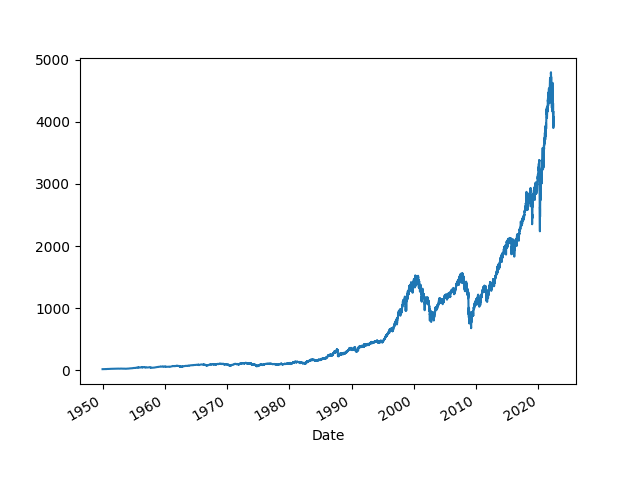

<AxesSubplot:xlabel='Date'>

In [41]:
%matplotlib notebook
daily_smp["Adj Close"].plot()

# Поделба на податоците на тренирачко и тестирачко множество

In [42]:
train_smp = daily_smp[daily_smp.index < "01-01-2005"].copy()
test_smp = daily_smp[daily_smp.index >= "01-01-2005"].copy()
len(train_smp), len(test_smp)

(13838, 4382)

# Трансформации на податоците

In [43]:
import numpy as np

def transform_close(df):
    df["close"] = df["Adj Close"]
    df["close_return"] = df["close"].pct_change(periods=1)
    df["close_diff"] = df["close"].diff(periods=1)
    df["close_log_return"] = np.log(df["close"]) - np.log(df["close"].shift(1))
    df.dropna(inplace=True)
    
transform_close(train_smp)
transform_close(test_smp)

<IPython.core.display.Javascript object>


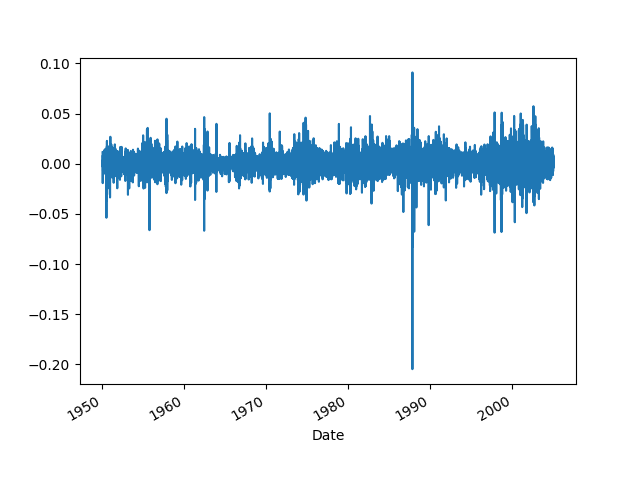

<AxesSubplot:xlabel='Date'>

In [44]:
train_smp["close_return"].plot()

<IPython.core.display.Javascript object>


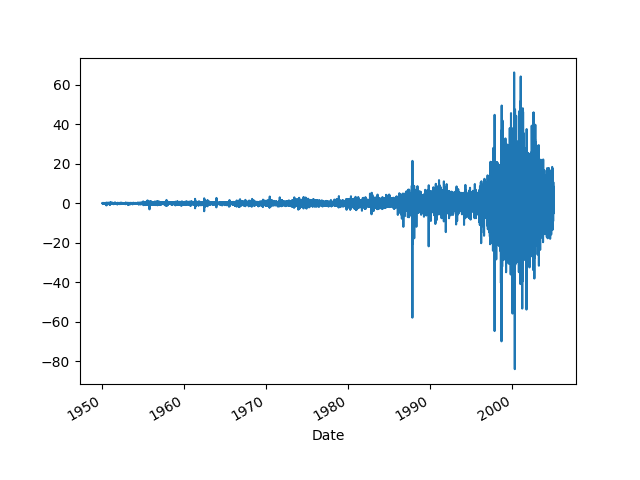

<AxesSubplot:xlabel='Date'>

In [45]:
train_smp["close_diff"].plot()

<IPython.core.display.Javascript object>


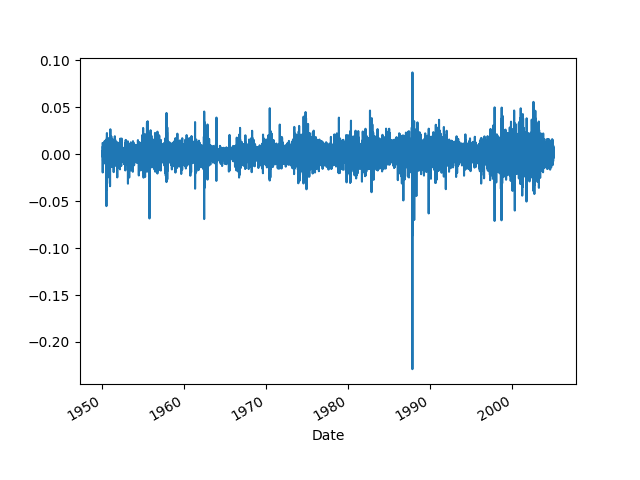

<AxesSubplot:xlabel='Date'>

In [46]:
train_smp["close_log_return"].plot()

# Стационарност

adf:  If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.
RESULT: stationary

kpss: If Test statistic < Critical Value and p-value < 0.05 – Fail to Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is trend stationary.
RESULT: not stationary

In [47]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = {title: adf_test[idx] for idx, title in enumerate(['Test Statistic','p-value','#Lags Used'])}
    for key,value in adf_test[4].items():
        adf_output[f'Critical Value ({key})'] = value

    return adf_output
    
def kpss_test(timeseries):
    kpss_test = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = {title: kpss_test[idx] for idx, title in enumerate(['Test Statistic','p-value','#Lags Used'])}
    for key,value in kpss_test[3].items():
        kpss_output[f'Critical Value ({key})'] = value

    return kpss_output
    
def interpret_results(adf_output, kpss_output):
    reject_h0 = []
    for test_output in [adf_output, kpss_output]:
        is_test_stat_larger = True
        for key, value in test_output.items():
            if "Critical" not in key:
                continue

            is_test_stat_larger = is_test_stat_larger and (test_output["Test Statistic"] > value)

        reject_h0.append(not is_test_stat_larger and test_output["p-value"] < 0.05)
        
    if reject_h0[0] and not reject_h0[1]:
        print("stationary")
    elif not reject_h0[0] and reject_h0[1]:
        print("non-stationary")
    elif not reject_h0[0] and not reject_h0[1]:
        print("trend-stationary")
    else:
        print("diff-stationary")

for series in ["close", "close_return", "close_diff", "close_log_return"]:
    adf_output = adf_test(train_smp[series])
    kpss_output = kpss_test(train_smp[series])
    print(series)
    interpret_results(adf_output, kpss_output)

/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


close
trend-stationary


/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


close_return
stationary
close_diff
diff-stationary
close_log_return
stationary


/home/eriden/repos/magisterska/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Авто-корелираност

The Durbin Watson test has values between 0 and 4. Below is the table containing values and their interpretations:

- 2: No autocorrelation. Generally, we assume 1.5 to 2.5 as no correlation.
- [0, 2): positive autocorrelation. The more close it to 0, the more signs of positive autocorrelation.
- (2 -4]: negative autocorrelation. The more close it to 4, the more signs of negative autocorrelation.

In [52]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS

for series in ["close_return", "close_log_return"]:
    X =np.arange(len(train_smp[series]))
    Y = np.asarray(train_smp[series])
    X = sm.add_constant(X)

    # Fit the ordinary least square method.
    ols_res = OLS(Y,X).fit()
    # apply durbin watson statistic on the ols residual
    dw = durbin_watson(ols_res.resid)
    print(f"{series} durbin-watson test value: {dw}")

close_return durbin-watson test value: 1.8397164676703857
close_log_return durbin-watson test value: 1.840325332394716
